In [2]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import os
import scipy.optimize as sc
import matplotlib as mpl
import glob
from matplotlib.path import Path
from collections import Counter
from tqdm import tqdm

In [7]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
Al_path = "/home/haue/repositories/Masters/data/bananas/Al"
P_path = "/home/haue/repositories/Masters/data/bananas/P"
Si_path = "/home/haue/repositories/Masters/data/bananas/Si"
Mg_path = "/home/haue/repositories/Masters/data/bananas/Mg"
outputdir = "/figure_output/"
#cuts ="/home/haue/repositories/Masters/data/cuts/idcuts.root" 
id0cuts ="/home/haue/repositories/Masters/data/cuts/id0cuts.root" 
cuts ="/home/haue/repositories/Masters/data/cuts/totcuts.root" 

In [4]:
#### Loading in data
Al_files = glob.glob(os.path.join(Al_path, "*mlio.root"))
P_files = glob.glob(os.path.join(P_path, "*mlio.root"))
Si_files = glob.glob(os.path.join(Si_path, "*mlio.root"))
Mg_files = glob.glob(os.path.join(Mg_path, "*mlio.root"))
#all_files = Al_files+P_files+Si_files+Mg_files


In [5]:
# Storing the data in a dictionary for easy access

###
# Note to better structure:
# i should load it in like data_collection["detector"]["isotope"]["treeentry"]
# or maybe better data_collection["isotope"]["detector"]["treeentry"] 
# instead of data_collection["isotope"]["treeentry"][detector id]
###

data_files = {
    "Al": Al_files,
    "P": P_files,
    "Mg": Mg_files,
    "Si": Si_files
}
data_collection = {
      "Al": {},
    "P": {},
    "Mg": {},
    "Si": {},
    "All": {}
}



for isotope, files in data_files.items():
    
    
    #initializes a dictionary entry for each isotope and gives it the name specified in the datafiles dictionary
    # each entry, eg. "E", contains 4 lists specifying the 4 id's of the telescopes in rising order
    data_collection[isotope] = {key: [[] for _ in range(4)] for key in
                                ["E", "fEdep", "bEdep", "angle", "Edep", "FI", "BI"]}
    
    file_progress = tqdm(files, desc=f"Processing {isotope}", unit="file", total=len(files))
    for file in file_progress:
        
        ## accesses the tree "a" in the root file
        r = uproot.open(file)["a"]
        ##Dummy array
        dum = r.arrays(["id", "E", "fEdep", "bEdep", "angle", "Edep", "FI", "BI"])
        
        ## converts it to an awkward array
        ids = ak.flatten(dum["id"])
        Es = ak.nan_to_num(ak.flatten(dum["E"]) / 1e3)
        fEdeps = ak.nan_to_num(ak.flatten(dum["fEdep"]) / 1e3)
        bEdeps = ak.nan_to_num(ak.flatten(dum["bEdep"]) / 1e3)
        angles = ak.nan_to_num(np.rad2deg(ak.flatten(dum["angle"])))
        Edeps = ak.nan_to_num(ak.flatten(dum["Edep"]) / 1e3)
        FIs = ak.flatten(dum["FI"])
        BIs = ak.flatten(dum["BI"])
        
        ##Creates entries in data_collection for each key and for each detector for each key
        for i in range(4):
            mask = (ids==i)
            data_collection[isotope]["E"][i].extend(Es[mask])
            data_collection[isotope]["fEdep"][i].extend(fEdeps[mask])
            data_collection[isotope]["bEdep"][i].extend(bEdeps[mask])
            data_collection[isotope]["angle"][i].extend(angles[mask])
            data_collection[isotope]["Edep"][i].extend(Edeps[mask])
            data_collection[isotope]["FI"][i].extend(FIs[mask])
            data_collection[isotope]["BI"][i].extend(BIs[mask])
        file_progress.set_postfix({"Completed": f"{file_progress.n}/{file_progress.total}"})
    #print(f"Processing done for {isotope}!")
    

tqdm.write("Combining all isotopes into 'All'...")      
## Create the "All" branch in data_collection
data_collection["All"] = {
    ## sum concatenates lists 
    key: [sum((data_collection[isotope][key][i] for isotope in data_files), []) for i in range(4)]
    for key in ["E", "fEdep", "bEdep", "angle", "Edep", "FI", "BI"]
}
tqdm.write("✅ All data combined successfully!")


Processing Al:   0%|          | 0/56 [00:00<?, ?file/s]

Processing Si: 100%|██████████| 11/11 [00:30<00:00,  2.74s/file, Completed=10/11]


Combining all isotopes into 'All'...
✅ All data combined successfully!


In [8]:
# Loading in cut values for regions of interest
cut = uproot.open(cuts)
#id0 = uproot.open(id0cuts)

#x1, y1 = id0["aboveregion"].values()
#x2, y2 = id0["vertical1"].values()
#x3, y3 = id0["vertical2"].values()
#xs = [x1/1e3, x2/1e3, x3/1e3]
#ys = [y1/1e3, y2/1e3, y3/1e3]

x1, y1 = cut["abovebanU1"].values()
x2, y2 = cut["abovebanU2"].values()
x3, y3 = cut["abovebanU3"].values()
xs = [x1/1e3, x2/1e3, x3/1e3]
ys = [y1/1e3, y2/1e3, y3/1e3]



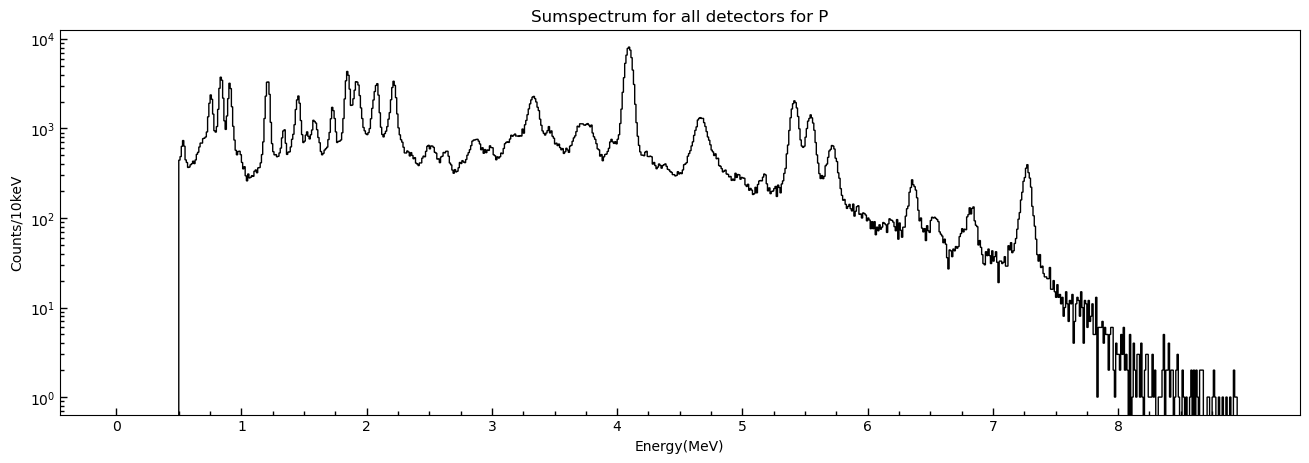

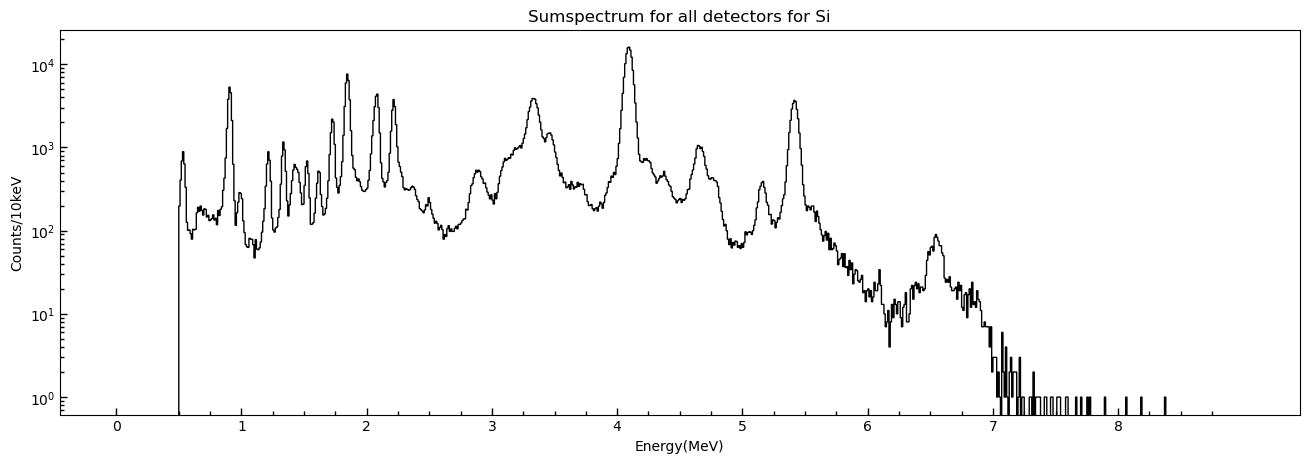

In [9]:
Energies_p_ = np.array([e for E_i in data_collection["P"]["E"][:-1] for e in E_i])
Energies_p = Energies_p_[Energies_p_>0.5]
id3_e = np.array(data_collection["P"]["E"][3])
id3_e = id3_e[id3_e>1]
np.append(Energies_p, id3_e)
bin_width = 0.01 # keV
bins = np.arange(0, 9 + bin_width, bin_width)
fig, ax = plt.subplots(figsize=(16, 5))
ax.hist(Energies_p, bins=bins, histtype='step', edgecolor='k', color='white', lw=1)
ax.set_yscale('log')
ax.set_xticks(np.arange(0.5, 9, 0.25), minor=True)
ax.set_xticks(np.arange(0, 9, 1))
ax.set_xlabel("Energy(MeV)")
ax.set_ylabel("Counts/10keV")
ax.set_title("Sumspectrum for all detectors for P")
plt.tick_params(axis='y', which='major', direction='in', length=5, width=1)
plt.tick_params(axis='y', which='minor', direction='in', length=3, width=1)
plt.tick_params(axis='x', which='major', direction='in', length=5, width=1)
plt.tick_params(axis='x', which='minor', direction='in', length=3, width=1)

Energies_p_ = np.array([e for E_i in data_collection["Si"]["E"][:-1] for e in E_i])
Energies_p = Energies_p_[Energies_p_>0.5]
id3_e = np.array(data_collection["Si"]["E"][3])
id3_e = id3_e[id3_e>1]
np.append(Energies_p, id3_e)
bin_width = 0.01 # keV
bins = np.arange(0, 9 + bin_width, bin_width)
fig, ax = plt.subplots(figsize=(16, 5))
ax.hist(Energies_p, bins=bins, histtype='step', edgecolor='k', color='white', lw=1)
ax.set_yscale('log')
ax.set_xticks(np.arange(0.5, 9, 0.25), minor=True)
ax.set_xticks(np.arange(0, 9, 1))
ax.set_xlabel("Energy(MeV)")
ax.set_ylabel("Counts/10keV")
ax.set_title("Sumspectrum for all detectors for Si")
plt.tick_params(axis='y', which='major', direction='in', length=5, width=1)
plt.tick_params(axis='y', which='minor', direction='in', length=3, width=1)
plt.tick_params(axis='x', which='major', direction='in', length=5, width=1)
plt.tick_params(axis='x', which='minor', direction='in', length=3, width=1)

# U1 Analysis


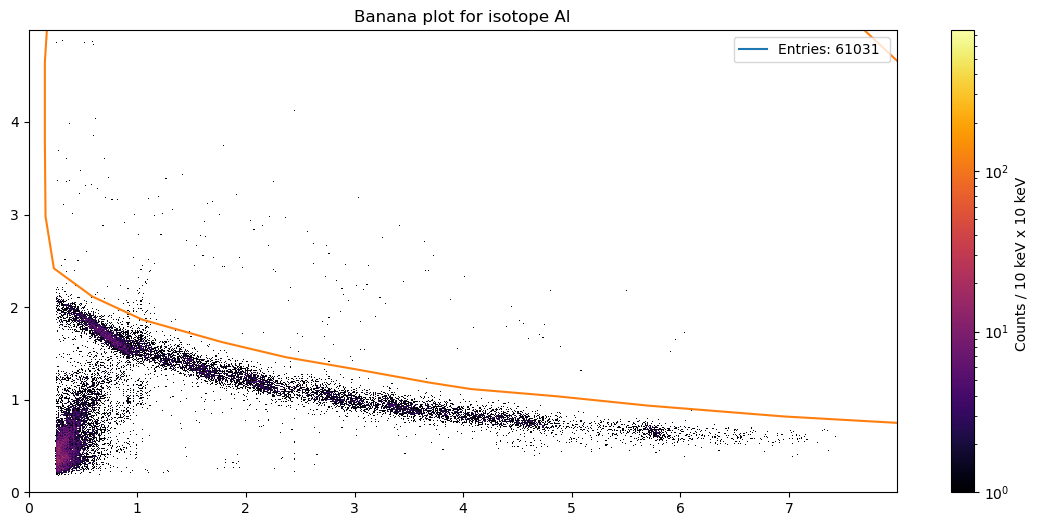

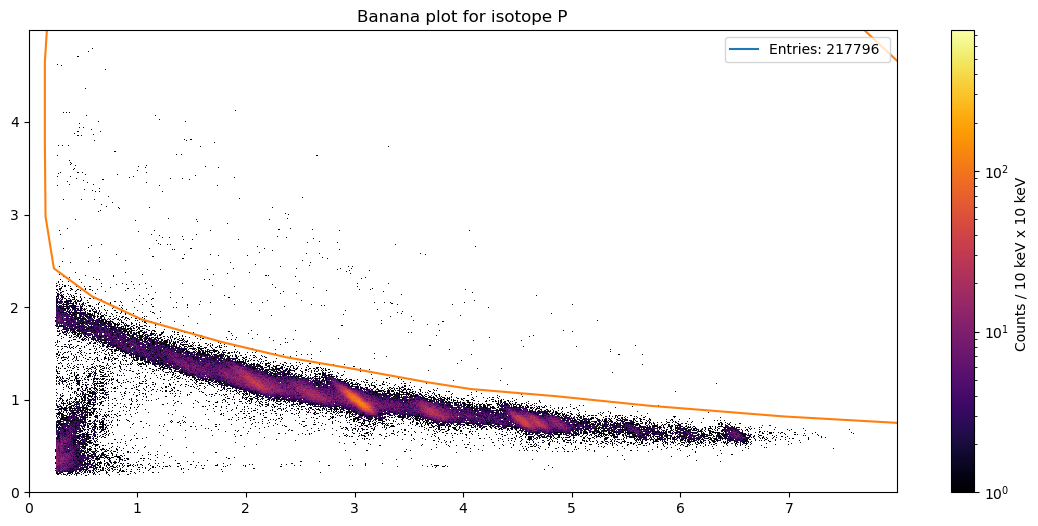

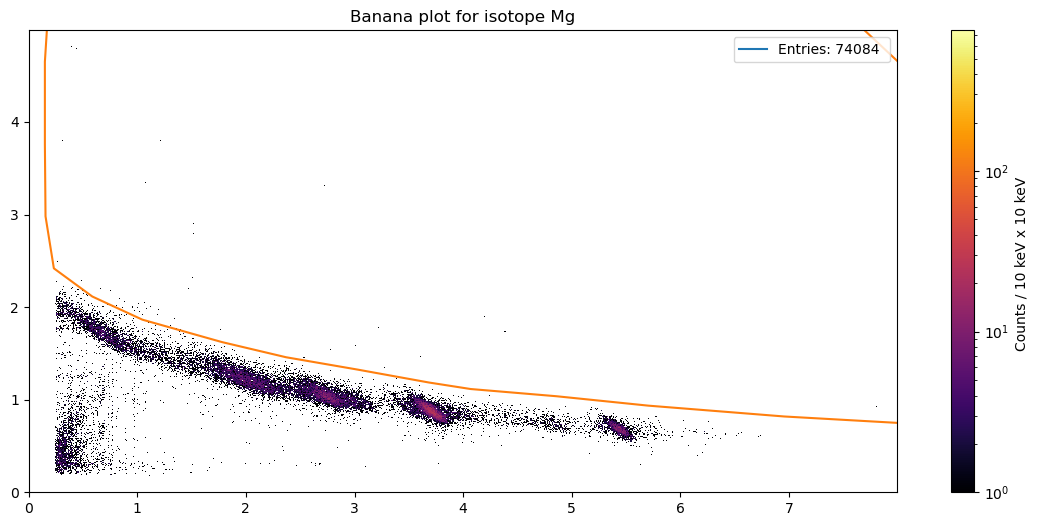

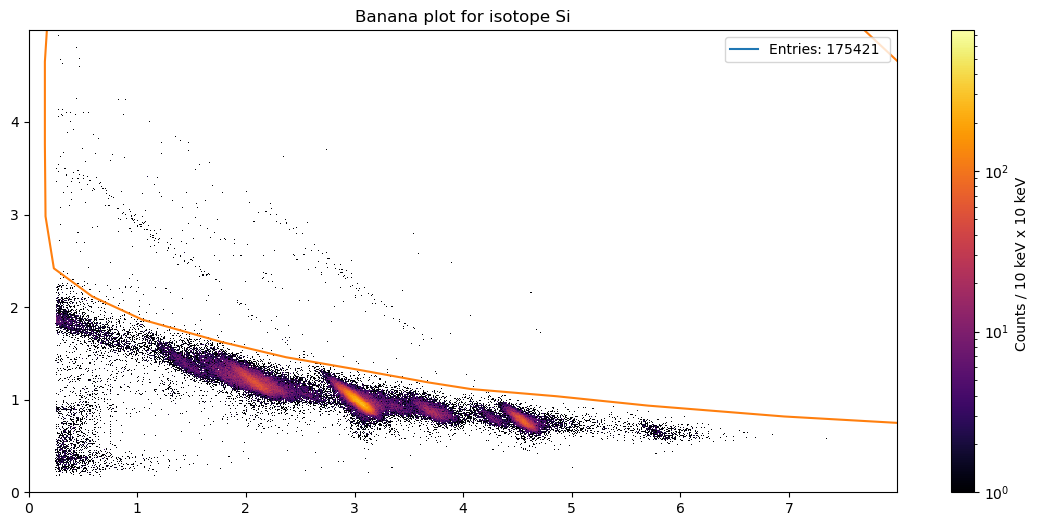

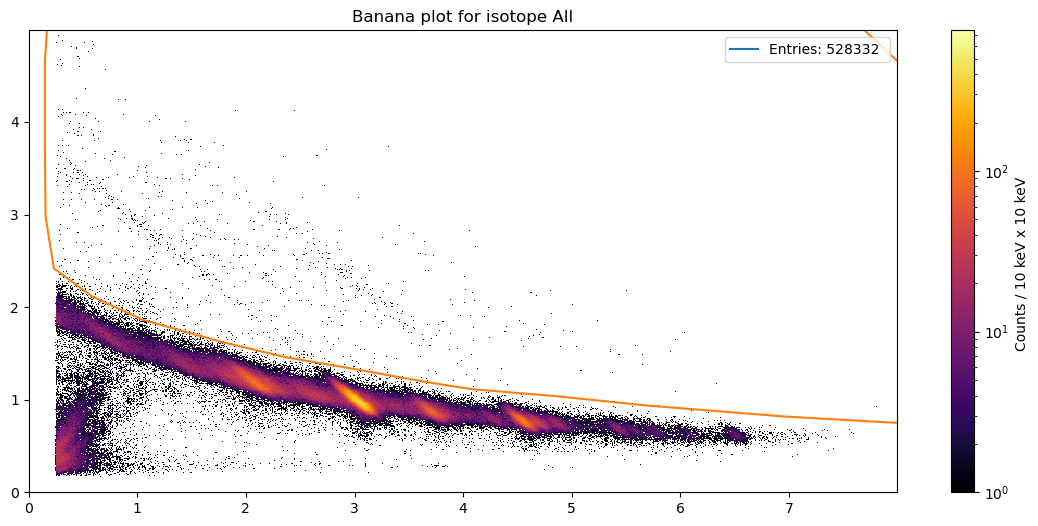

In [10]:
## Plotting banana plots for the 4 isotopes and the total spektrum
for data in data_collection:
    plt.figure(figsize=(14,6))
    plt.hist2d(data_collection[data]["bEdep"][0], data_collection[data]["fEdep"][0], bins=(np.arange(0, 8, 0.01), np.arange(0, 5, 0.01)),
                   cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(vmin=1, vmax=750), rasterized=True)
    plt.title(f"Banana plot for isotope {data}")
    length = len(data_collection[data]["bEdep"][0])
    plt.plot([], [], label=f"Entries: {length} ")
    plt.legend(loc='upper right')
    cbar = plt.colorbar()
    cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
    plt.plot(xs[0], ys[0])

Text(0.5, 1.0, 'Histogram of Energies observed above the banana in P')

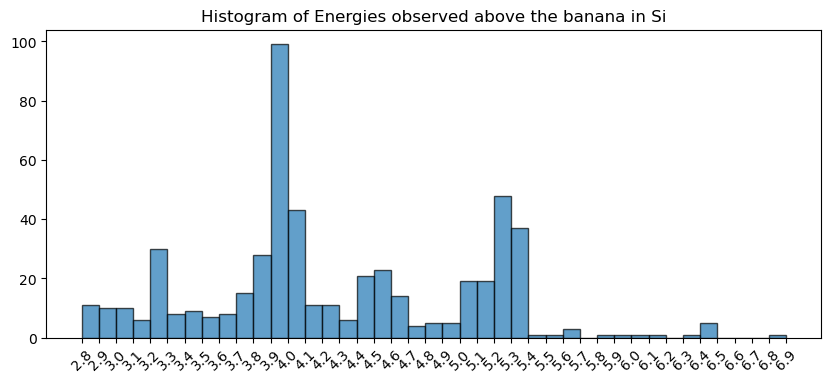

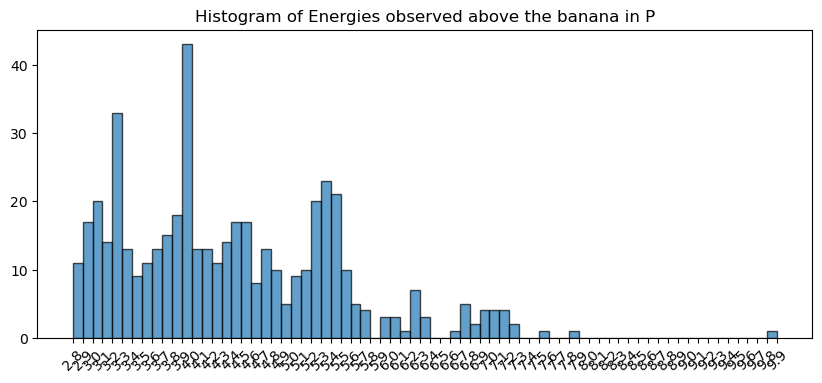

In [11]:
### Try to count events for P and Si

polygon = np.column_stack((xs[0], ys[0]))
polygon_path = Path(polygon)    
    
points_p = np.column_stack((data_collection["P"]["bEdep"][0], data_collection["P"]["fEdep"][0]))
points_si = np.column_stack((data_collection["Si"]["bEdep"][0], data_collection["Si"]["fEdep"][0]))
mask_p = polygon_path.contains_points(points_p)
mask_si = polygon_path.contains_points(points_si)
p_E = np.array(data_collection["P"]["E"][0])[mask_p]
p_fedep = np.array(data_collection["P"]["fEdep"][0])[mask_p]
p_bedep = np.array(data_collection["P"]["bEdep"][0])[mask_p]
p_fi = np.array(data_collection["P"]["FI"][0])[mask_p]
p_bi = np.array(data_collection["P"]["BI"][0])[mask_p]
p_angle = np.array(data_collection["P"]["angle"][0])[mask_p]
si_E = np.array(data_collection["Si"]["E"][0])[mask_si]
si_fedep = np.array(data_collection["Si"]["fEdep"][0])[mask_si]
si_bedep = np.array(data_collection["Si"]["bEdep"][0])[mask_si]
si_fi = np.array(data_collection["Si"]["FI"][0])[mask_si]
si_bi = np.array(data_collection["Si"]["BI"][0])[mask_si]
si_angle = np.array(data_collection["Si"]["angle"][0])[mask_si]
   
rounded_si_E = np.round(si_E,1)
rounded_p_E = np.round(p_E,1)
counts_p = Counter(rounded_p_E)
counts_si = Counter(rounded_si_E)    

plt.figure(figsize=(10,4))
plt.hist(rounded_si_E, bins=np.arange(min(rounded_si_E), max(rounded_si_E) + 0.1, 0.1), edgecolor="black", alpha=0.7)
plt.xticks(np.arange(min(rounded_si_E), max(rounded_si_E) + 0.1, 0.1), rotation=45)
plt.title("Histogram of Energies observed above the banana in Si")

plt.figure(figsize=(10,4))
plt.hist(rounded_p_E, bins=np.arange(min(rounded_p_E), max(rounded_p_E) + 0.1, 0.1), edgecolor="black", alpha=0.7)
plt.xticks(np.arange(min(rounded_p_E), max(rounded_p_E) + 0.1, 0.1), rotation=45)
plt.title("Histogram of Energies observed above the banana in P")

In [12]:
#Based on the above regions of interest is defined
regions_of_interest_p = [(3.1,3.3),(3.9, 4.1), (4.4,4.8), (5.2,5.5)]
regions_of_interest_si = [(3.2,3.4),(3.9, 4.1), (4.4,4.7), (5.0, 5.2),(5.2,5.4)]

Counts used to make linear fit for P:  [39, 58, 54, 61]
Counts used to make linear fit for Si:  [28, 149, 56, 30, 89]


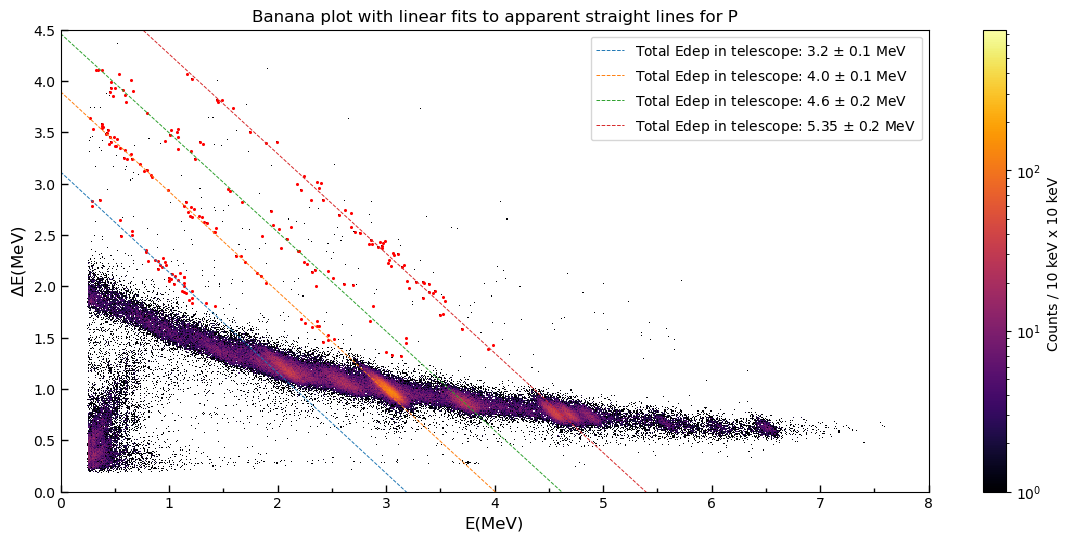

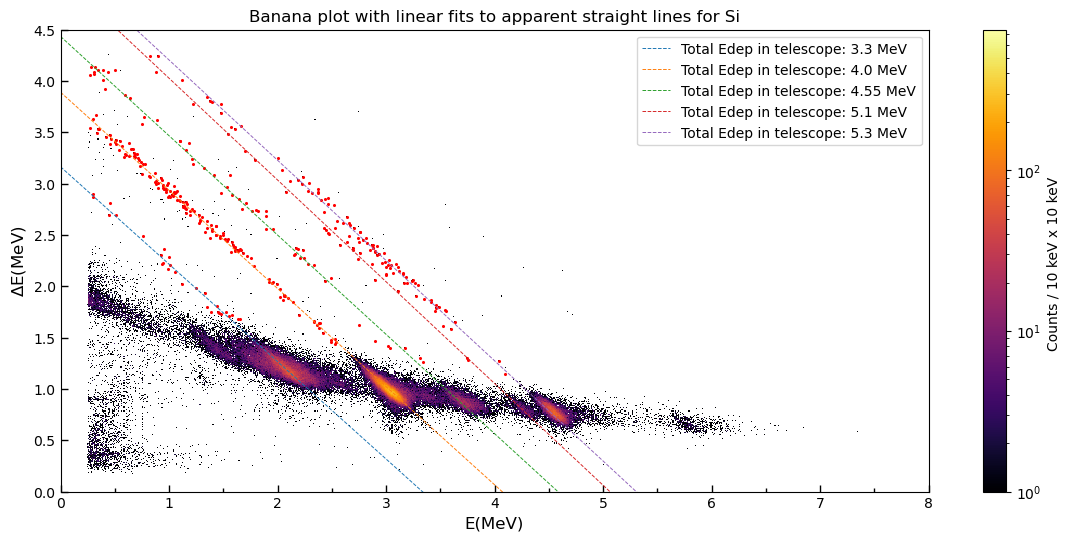

In [13]:
##### For P
def linfunc(x, a, b):
    return a*x+b

plt.figure(figsize=(14,6))
plt.hist2d(data_collection["P"]["bEdep"][0], data_collection["P"]["fEdep"][0], bins=(np.arange(0, 8, 0.01), np.arange(0, 4.5, 0.01)),
                   cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(vmin=1, vmax=750), rasterized=True)
cbar = plt.colorbar()
cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")

a_vals_p = []
b_vals_p = []
counts_online_p = []
## Intervals based on the previous histogram.
for i in regions_of_interest_p:
    mask = (p_E>=i[0]) & (p_E<=i[1])
    ef_p = p_fedep[mask]
    eb_p = p_bedep[mask]
    plt.scatter(eb_p,ef_p, marker='o', s=1.5, color='r')
    popt, _ = sc.curve_fit(linfunc, eb_p, ef_p)
    a, b = popt
    a_vals_p.append(a)
    b_vals_p.append(b)
    counts_online_p.append(len(ef_p))
    ##Fitting to the data points that lies around a specific energy
    fit_x = np.linspace(0, 6, 100)
    fit_y = linfunc(fit_x, a, b)
    plt.plot(fit_x,fit_y, ls='--', lw=0.7,
            label=f"Total Edep in telescope: {np.round((i[0]+i[1])/2, 2)} $\pm$ {np.round(np.round((i[0]+i[1])/2, 1)-i[0],1)} MeV")
plt.legend(loc='upper right')
plt.gca().set_xticks(np.arange(0, 8, 0.5), minor=True)
plt.xlim(0, 8)
plt.ylim(0,4.5)
plt.tick_params(axis='y', which='major', direction='in', length=5, width=1)
plt.tick_params(axis='y', which='minor', direction='in', length=3, width=1)
plt.tick_params(axis='x', which='major', direction='in', length=5, width=1)
plt.tick_params(axis='x', which='minor', direction='in', length=3, width=1)
plt.xlabel("E(MeV)", fontsize=12)
plt.ylabel(r"$\Delta$E(MeV)", fontsize=12)
plt.title("Banana plot with linear fits to apparent straight lines for P")
print("Counts used to make linear fit for P: ",counts_online_p)
###################################################################################################################
### For Si

plt.figure(figsize=(14,6))
plt.hist2d(data_collection["Si"]["bEdep"][0], data_collection["Si"]["fEdep"][0], bins=(np.arange(0, 8, 0.01), np.arange(0, 4.5, 0.01)),
                   cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(vmin=1, vmax=750), rasterized=True)
cbar = plt.colorbar()
cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")

a_vals_si = []
b_vals_si = []
counts_online_si = []
## Intervals based on the previous histogram.
for i in regions_of_interest_si:
    mask = (si_E>=i[0]) & (si_E<=i[1])
    ef_si = si_fedep[mask]
    eb_si = si_bedep[mask]
    plt.scatter(eb_si,ef_si, marker='o', s=1.5, color='r')
    popt, _ = sc.curve_fit(linfunc, eb_si, ef_si)
    a, b = popt
    a_vals_si.append(a)
    b_vals_si.append(b)
    counts_online_si.append(len(ef_si))
    ##Fitting to the data points that lies around a specific energy
    fit_x = np.linspace(0, 6, 100)
    fit_y = linfunc(fit_x, a, b)
    plt.plot(fit_x,fit_y, ls='--', lw=0.7,
            label=f"Total Edep in telescope: {np.round((i[0]+i[1])/2, 2)} MeV")

plt.legend(loc='upper right')
plt.gca().set_xticks(np.arange(0, 8, 0.5), minor=True)
plt.xlim(0, 8)
plt.ylim(0,4.5)
plt.tick_params(axis='y', which='major', direction='in', length=5, width=1)
plt.tick_params(axis='y', which='minor', direction='in', length=3, width=1)
plt.tick_params(axis='x', which='major', direction='in', length=5, width=1)
plt.tick_params(axis='x', which='minor', direction='in', length=3, width=1)
plt.xlabel("E(MeV)", fontsize=12)
plt.ylabel(r"$\Delta$E(MeV)", fontsize=12)
plt.title("Banana plot with linear fits to apparent straight lines for Si")
print("Counts used to make linear fit for Si: ",counts_online_si)

In [14]:
"""
plt.figure(figsize=(14,6))
##Plotting entire banana spectrum
plt.hist2d(data_collection["P"]["bEdep"][0], data_collection["P"]["fEdep"][0], bins=(np.arange(0, 8, 0.01), np.arange(0, 4.5, 0.01)),
                   cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(vmin=1, vmax=750), rasterized=True)
plt.title(f"Banana plot for isotope P")
cbar = plt.colorbar()
cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")

##Plotting the lines based on the fits made in the last box
for a,b, i, j in zip(a_vals_p, b_vals_p, regions_of_interest_p,range(len(regions_of_interest_p))):
    fit_x = np.linspace(0, 7, 100)
    fit_y = linfunc(fit_x, a, b)
    plt.plot(fit_x,fit_y, ls='--', lw=0.5, alpha=0.9,
             label=rf"Total Edep in telescope: {np.round((i[0]+i[1])/2, 1)} $\pm$ {np.round(np.round((i[0]+i[1])/2, 1)-i[0],1)}  MeV, {counts_online_p[j]} counts")

plt.legend(loc='upper right')
plt.gca().set_xticks(np.arange(0, 8, 0.5), minor=True)
plt.xlim(0, 8)
plt.ylim(0,4)
plt.tick_params(axis='y', which='major', direction='in', length=5, width=1)
plt.tick_params(axis='y', which='minor', direction='in', length=3, width=1)
plt.tick_params(axis='x', which='major', direction='in', length=5, width=1)
plt.tick_params(axis='x', which='minor', direction='in', length=3, width=1)

plt.xlabel("E(MeV)", fontsize=12)
plt.ylabel(r"$\Delta$E(MeV)", fontsize=12)

###################################################################################################################
plt.figure(figsize=(14,6))
##Plotting entire banana spectrum
plt.hist2d(data_collection["Si"]["bEdep"][0], data_collection["Si"]["fEdep"][0], bins=(np.arange(0, 8, 0.01), np.arange(0, 4.5, 0.01)),
                   cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(vmin=1, vmax=750), rasterized=True)
plt.title(f"Banana plot for isotope Si")
cbar = plt.colorbar()
cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")

##Plotting the lines based on the fits made in the last box
for a,b, i, j in zip(a_vals_si, b_vals_si, regions_of_interest_si,range(len(regions_of_interest_si))):
    fit_x = np.linspace(0, 7, 100)
    fit_y = linfunc(fit_x, a, b)
    plt.plot(fit_x,fit_y, ls='--', lw=0.5, alpha=0.9,
             label=rf"Total Edep in telescope: {np.round((i[0]+i[1])/2, 1)} $\pm$ {np.round(np.round((i[0]+i[1])/2, 1)-i[0],1)}  MeV, {counts_online_si[j]} counts")

plt.legend(loc='upper right')
plt.gca().set_xticks(np.arange(0, 8, 0.5), minor=True)
plt.xlim(0, 8)
plt.ylim(0,4)
plt.tick_params(axis='y', which='major', direction='in', length=5, width=1)
plt.tick_params(axis='y', which='minor', direction='in', length=3, width=1)
plt.tick_params(axis='x', which='major', direction='in', length=5, width=1)
plt.tick_params(axis='x', which='minor', direction='in', length=3, width=1)

plt.xlabel("E(MeV)", fontsize=12)
plt.ylabel(r"$\Delta$E(MeV)", fontsize=12)
"""

'\nplt.figure(figsize=(14,6))\n##Plotting entire banana spectrum\nplt.hist2d(data_collection["P"]["bEdep"][0], data_collection["P"]["fEdep"][0], bins=(np.arange(0, 8, 0.01), np.arange(0, 4.5, 0.01)),\n                   cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(vmin=1, vmax=750), rasterized=True)\nplt.title(f"Banana plot for isotope P")\ncbar = plt.colorbar()\ncbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")\n\n##Plotting the lines based on the fits made in the last box\nfor a,b, i, j in zip(a_vals_p, b_vals_p, regions_of_interest_p,range(len(regions_of_interest_p))):\n    fit_x = np.linspace(0, 7, 100)\n    fit_y = linfunc(fit_x, a, b)\n    plt.plot(fit_x,fit_y, ls=\'--\', lw=0.5, alpha=0.9,\n             label=rf"Total Edep in telescope: {np.round((i[0]+i[1])/2, 1)} $\\pm$ {np.round(np.round((i[0]+i[1])/2, 1)-i[0],1)}  MeV, {counts_online_p[j]} counts")\n\nplt.legend(loc=\'upper right\')\nplt.gca().set_xticks(np.arange(0, 8, 0.5), minor=True)\nplt.xlim(0, 8)\nplt.ylim(0,4)\nplt.ti

In [15]:
## Hit patterns for events observed in P
total_pfi = []
total_pbi = []
p_angles = []
for i in regions_of_interest_p:
    mask = (p_E>=i[0]) & (p_E<=i[1])
    fi_p = p_fi[mask]
    bi_p = p_bi[mask]
    total_pfi.append(fi_p)
    total_pbi.append(bi_p)
    p_angles.append(p_angle[mask])
    """
    plt.figure(figsize=(9,5))
    plt.hist2d(fi_p-0.5, bi_p-0.5, bins=(np.arange(0.5, 17.5, 1), np.arange(0.5,17.5,1)),
                   cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(vmin=1, vmax=3), rasterized=True)
    plt.title(f"Hit pattern for fit at E = {np.round((i[0]+i[1])/2, 1)} $\pm$ {np.round(np.round((i[0]+i[1])/2, 1)-i[0],1)}  MeV for P")
    cbar = plt.colorbar()
    cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
    plt.xlabel('Front index')
    plt.ylabel('Back index')
    """
##############################################################################################################33
#Hit patterns for events observed in Si
total_sifi = []
total_sibi = []
si_angles = []
for i in regions_of_interest_si:
    mask = (si_E>=i[0]) & (si_E<=i[1])
    fi_si = si_fi[mask]
    bi_si = si_bi[mask]
    total_sifi.append(fi_si)
    total_sibi.append(bi_si)
    si_angles.append(si_angle[mask])
    """
    plt.figure(figsize=(9,5))
    plt.hist2d(fi_si-0.5, bi_si-0.5, bins=(np.arange(0.5, 17.5, 1), np.arange(0.5,17.5,1)),
                   cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(vmin=1, vmax=3), rasterized=True)
    plt.title(f"Hit pattern for fit at E = {np.round((i[0]+i[1])/2, 1)} $\pm$ {np.round(np.round((i[0]+i[1])/2, 1)-i[0],1)}  MeV for Si")
    cbar = plt.colorbar()
    cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
    plt.xlabel('Front index')
    plt.ylabel('Back index')
    """

Text(0, 0.5, 'Back index')

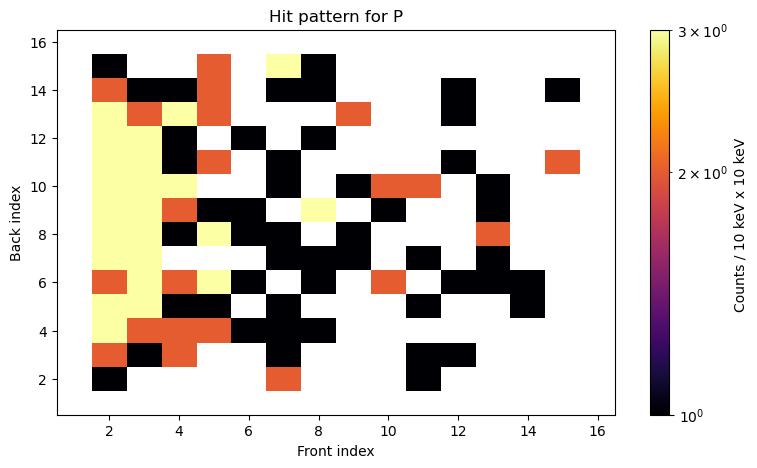

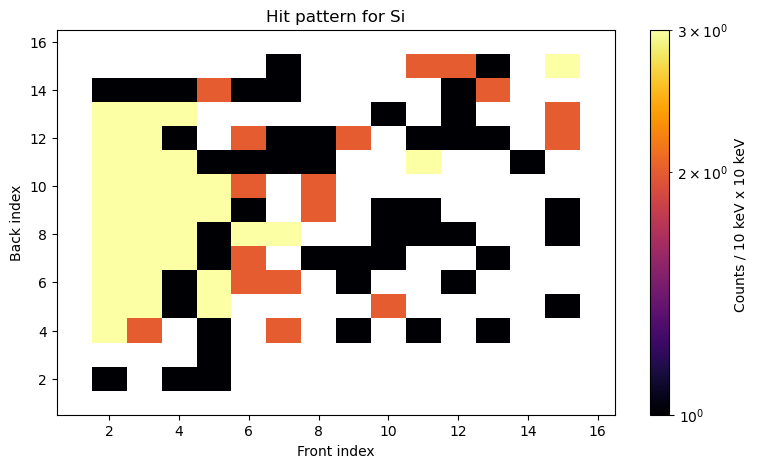

In [16]:
##Total hitpatterns
plt.figure(figsize=(9,5))
plt.hist2d(np.array(ak.flatten(total_pfi))-0.5, np.array(ak.flatten(total_pbi))-0.5, bins=(np.arange(0.5, 17.5, 1), np.arange(0.5,17.5,1)),
                   cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(vmin=1, vmax=3), rasterized=True)
plt.title(f"Hit pattern for P")
cbar = plt.colorbar()
cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
plt.xlabel('Front index')
plt.ylabel('Back index')

plt.figure(figsize=(9,5))
plt.hist2d(np.array(ak.flatten(total_sifi))-0.5, np.array(ak.flatten(total_sibi))-0.5, bins=(np.arange(0.5, 17.5, 1), np.arange(0.5,17.5,1)),
cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(vmin=1, vmax=3), rasterized=True)
plt.title(f"Hit pattern for Si")
cbar = plt.colorbar()
cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
plt.xlabel('Front index')
plt.ylabel('Back index')